In [5]:
!python -c "import torch.utils"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/bask/homes/g/gmmg6904/.local/lib/python3.11/site-packages/torch/utils/__init__.py", line 5, in <module>
    from .throughput_benchmark import ThroughputBenchmark
  File "/bask/homes/g/gmmg6904/.local/lib/python3.11/site-packages/torch/utils/throughput_benchmark.py", line 3, in <module>
    import torch._C
ModuleNotFoundError: No module named 'torch._C'


In [9]:
%pip install --force-reinstall torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl (797.1 MB)
  Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl

In [19]:
%pip install plothelp

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import random, os

from cloudcasting.dataset import SatelliteDataset


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.mps.manual_seed(seed)
    
seed_everything(42)

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [9]:
from diffusers import DDPMScheduler, UNet2DModel
from cloudcasting.constants import NUM_CHANNELS


class ConditionedUnet(nn.Module):
    history_steps: int
    def __init__(self, image_size, history_steps = 1):
        super().__init__()

        self.history_steps = history_steps

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (previous timesteps)
        self.model = UNet2DModel(
            sample_size=image_size,  # the target image resolution
            in_channels=NUM_CHANNELS + history_steps * NUM_CHANNELS,  # noise input + conditioning information
            out_channels=NUM_CHANNELS,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(
                128, 
                256, 
                # 512,
            ),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  # a regular ResNet downsampling block
                # "DownBlock2D",  # a regular ResNet downsampling block

                # "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                # "AttnDownBlock2D",
            ),
            up_block_types=(
                # "AttnUpBlock2D",
                # "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
                "UpBlock2D",  # a regular ResNet upsampling block
                # "UpBlock2D",  # a regular ResNet upsampling block
            ),
            add_attention = False,  # blows up memory with attention -- maybe do latent diffusion
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, noisy_image, conditioning, t):

        # stack noisy image and conditioning info along the time axis
        stacked = torch.cat([noisy_image, conditioning], dim=-3) 
        # print(f"{stacked.shape=}")

        # reshape to (batch, channels*time, height, width)
        net_input = stacked.reshape(-1, stacked.shape[-4] * stacked.shape[-3], *stacked.shape[-2:])

        return self.model(net_input, t).sample
    


In [10]:
from cloudcasting.constants import DATA_INTERVAL_SPACING_MINUTES

TRAINING_DATA_PATH = "/bask/projects/v/vjgo8416-climate/shared/data/eumetsat/training/2022_training_nonhrv.zarr"
HISTORY_STEPS = 1

# Instantiate the torch dataset object
dataset = SatelliteDataset(
    zarr_path=TRAINING_DATA_PATH,
    start_time="2022-01-31",
    end_time=None,
    history_mins=(HISTORY_STEPS - 1) * DATA_INTERVAL_SPACING_MINUTES,
    forecast_mins=15,
    sample_freq_mins=15,
    nan_to_num=True,
)

In [11]:
# Number of complete samples in the dataset
# - this includes overlapping periods, not completely distinct periods
n_samples = len(dataset)
print(n_samples)

# nan percentage
# print(f"NaN percentage: {np.mean(np.isnan(dataset.ds)).compute()}")

12291


In [12]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

batch_size = 2
num_workers = 0

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

# train_dataloader = DataLoader(
#     dataset=dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
# )


In [13]:
dl = iter(train_dataloader)
X, y = next(dl)

assert X.shape == y.shape
while torch.mean(X) == -1:
    print('aaaaah')
    X, y = next(iter(train_dataloader))

In [14]:
# Instantiate the model
# Calculate required crop for the input dims to be divisible by 16
x_cropped_shape = [(size // 16) * 16 for size in X.shape[-2:]]
# model = ConditionedUnet(x_cropped_shape, history_steps=HISTORY_STEPS).to(device)

In [15]:
def crop(x):
    # Calculate required crop for the input dims to be divisible by 16
    x_cropped_shape = [(size // 16) * 16 for size in x.shape[-2:]]
    return x[..., :x_cropped_shape[0], :x_cropped_shape[1]]

class MaskedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss()
        
    def forward(self, x, y, nan_mask, **kwargs):
        return self.loss.forward(torch.where(nan_mask, 0, x), torch.where(nan_mask, 0, y), **kwargs)
    


In [16]:
####### < -- STOP -- > ##########################################################################################

In [17]:
# example sample
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
# Get some data and prepare the corrupted version
X = crop(X.to(device) * 2 - 1)  # Data on the GPU (mapped to (-1, 1)) (????)

y = crop(y.to(device) * 2 - 1)
noise = torch.randn_like(y)  # base noise on the target image
timesteps = torch.randint(0, 999, (X.shape[0],)).long().to(device)
noisy_y = noise_scheduler.add_noise(y, noise, timesteps)  # Note that we pass in the target y
# Predict the noise based on previous images and the noisy forecast target
# pred = model(noisy_y, X, timesteps).reshape(y.shape)[0]
# print(f"{pred.shape=}")

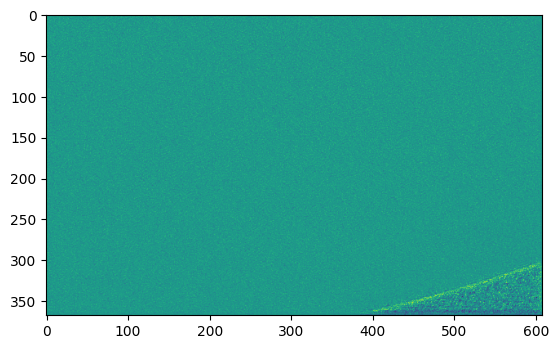

In [18]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

ax.imshow(pred[1].to("cpu").squeeze().detach().numpy())

In [ ]:
from tqdm.notebook import tqdm
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

# How many runs through the data should we do?
n_epochs = 1

# Our loss function
loss_fn = MaskedLoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []
best_loss = 999
best_model = None



# The training loop
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(tqdm(train_dataloader)):
        
        if torch.mean(x) == -1:
            continue

        # Get some data and prepare the corrupted version
        x = crop(x.to(device))
        y = crop(y.to(device))
        
        # must be before data rescaling, after cropping
        nan_mask = (x == -1) & (y == -1)
        
        x, y = x * 2 - 1, y  * 2 - 1
        # Calculate required crop for the input dims to be divisible by 16
        y_cropped_shape = [(size // 16) * 16 for size in y.shape[-2:]]
        y_cropped = y[..., :y_cropped_shape[0], :y_cropped_shape[1]]
        noise = torch.randn_like(y)  # base noise on the target image
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)  # Note that we pass in the target y

        # Predict the noise based on previous images and the noisy forecast target
        pred = model(noisy_y, x, timesteps).reshape(y.shape)
        

        # Calculate the loss
        loss = loss_fn(pred, noise, nan_mask)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        print(f"Loss: {loss.item():05f}")
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")
    
    torch.save(best_model, f'best-model-epoch-{epoch}.pt')

# View the loss curve
plt.plot(losses)

  0%|          | 0/6146 [00:00<?, ?it/s]

Loss: 1.053681
Loss: 0.971095
Loss: 0.958047
Loss: 0.939332
Loss: 0.919464
Loss: 0.887700
Loss: 0.850905
Loss: 0.867233
Loss: 0.763298
Loss: 0.831848
Loss: 0.709193
Loss: 0.736766
Loss: 0.409235
Loss: 0.335827
Loss: 0.394319
Loss: 0.462372
Loss: 0.260349
Loss: 0.335655
Loss: 0.233950
Loss: 0.273885
Loss: 0.327135
Loss: 0.279276
Loss: 0.200800
Loss: 0.218487
Loss: 0.179967
Loss: 0.240286
Loss: 0.136688
Loss: 0.146092
Loss: 0.310850
Loss: 0.126109
Loss: 0.107948
Loss: 0.189052
Loss: 0.114104
Loss: 0.138992
Loss: 0.102351
Loss: 0.162916
Loss: 0.104194
Loss: 0.090283
Loss: 0.076959
Loss: 0.242597
Loss: 0.403118
Loss: 0.081789
Loss: 0.122649
Loss: 0.090681
Loss: 0.149621
Loss: 0.098855
Loss: 0.537208
Loss: 0.140305
Loss: 0.191013
Loss: 0.083237
Loss: 0.209044
Loss: 0.082145
Loss: 0.100981
Loss: 0.071355
Loss: 0.076063
Loss: 0.445702
Loss: 0.079515
Loss: 0.153411
Loss: 0.065245
Loss: 0.075779
Loss: 0.063714
Loss: 0.292990
Loss: 0.061617
Loss: 0.060617
Loss: 0.098016
Loss: 0.123837
Loss: 0.06

In [ ]:
# example sample
from tqdm.notebook import tqdm
X, y = next(dl)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
# Get some data and prepare the corrupted version
X = crop(X[1:].to(device) * 2 - 1)  # Data on the GPU (mapped to (-1, 1)) (????)
sampled_noise = torch.randn_like(crop(y[1:])).to(device)


# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        model_0 = torch.load("best-model-epoch-0.pt").to(device)
        residual = model_0(sampled_noise, X, t).reshape(sampled_noise.shape)
        print(f"{residual.shape=}")

    # Update sample with step
    sampled_noise = noise_scheduler.step(residual, t, sampled_noise).prev_sample
    print(f"{sampled_noise.shape=}")

sampled_noise.shape=torch.Size([1, 11, 1, 368, 608])
for_grid.shape=torch.Size([11, 1, 368, 608])


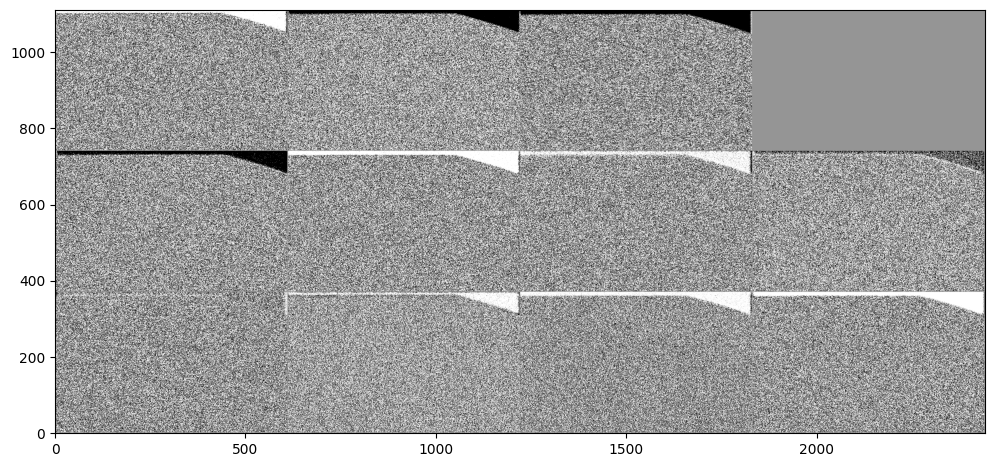

In [58]:
# Show the results

import torchvision

print(f"{sampled_noise.shape=}")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for_grid = sampled_noise.detach().cpu().clip(-1, 1)[0]
print(f"{for_grid.shape=}")
grid = torchvision.utils.make_grid(for_grid, nrow=4)[0]
ax.imshow(grid, cmap="Greys", origin='lower')

In [38]:
%pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
